In [4]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

# Cargamos el dataframe
df_secop = pd.read_csv("SECOP_II.csv", low_memory=False)

# 4) INSPECCIÓN RÁPIDA (útil para depurar nombres de columnas)
print("Dimensiones (filas, columnas):", df_secop.shape)
print("Primeras columnas:", list(df_secop.columns)[:12])

df_secop.head()



Dimensiones (filas, columnas): (81561, 36)
Primeras columnas: ['Nombre Entidad', 'Nit Entidad', 'Departamento', 'Ciudad', 'Orden', 'Sector', 'Rama', 'Estado Contrato', 'Descripcion del Proceso', 'Tipo de Contrato', 'Modalidad de Contratacion', 'Fecha de Firma']


,Nombre Entidad,Nit Entidad,Departamento,Ciudad,Orden,Sector,Rama,Estado Contrato,Descripcion del Proceso,Tipo de Contrato,...,Valor Pendiente de Pago,Dias adicionados,Presupuesto General de la Nacion – PGN,Sistema General de Participaciones,Sistema General de Regalías,"Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas)",Recursos de Credito,Recursos Propios,Objeto del Contrato,Duración del contrato
0,INVIAS,"800,215,807",Distrito Capital de Bogotá,Bogotá,Nacional,Transporte,Ejecutivo,Modificado,PRESTAR SERVICIOS PROFESIONALES; PARA ATENDER ...,Prestación de servicios,...,"$89,821,124",0,"$89,821,124",$0,$0,0,$0,$0,PRESTAR SERVICIOS PROFESIONALES; PARA ATENDER ...,262 Dia(s)
1,MINISTERIO DE TRANSPORTE*,"899,999,055",Distrito Capital de Bogotá,Bogotá,Nacional,Transporte,Ejecutivo,Modificado,PRESTAR LOS SERVICIOS PROFESIONALES PARA ADMIN...,Prestación de servicios,...,"$3,250,000",56,"$88,250,000",$0,$0,0,$0,$0,PRESTAR LOS SERVICIOS PROFESIONALES PARA ADMIN...,249 Dia(s)
2,INVIAS,"800,215,807",Distrito Capital de Bogotá,Bogotá,Nacional,Transporte,Ejecutivo,Cerrado,PRESTAR SERVICIOS PROFESIONALES; EN TEMAS JURI...,Prestación de servicios,...,"$366,667",0,"$11,000,000",$0,$0,0,$0,$0,PRESTAR SERVICIOS PROFESIONALES; EN TEMAS JURI...,61 Dia(s)
3,TERMINAL DE TRANSPORTE S.A,"860,052,155",Distrito Capital de Bogotá,Bogotá,Territorial,Transporte,Ejecutivo,Modificado,Suministro e instalación de rack de bicicletas...,Compraventa,...,"$450,000,000",229,$0,$0,$0,0,$0,"$450,000,000",Suministro e instalación de rack de bicicletas...,10 Mes(es)
4,SECRETARÍA DISTRITAL DE MOVILIDAD,"8,999,990,619",Distrito Capital de Bogotá,Bogotá,Territorial,Transporte,Ejecutivo,Modificado,Realizar la evaluación y proponer una regulaci...,Consultoría,...,"$757,755,110",0,$0,$0,$0,0,$0,$0,Realizar la evaluación y proponer una regulaci...,Dia(s)


In [5]:
# Realizamos la normalizacion de la tabla

# Convertimos valores monetarios a numérico
if "Valor del Contrato" in df_secop.columns:
    df_secop["Valor del Contrato"] = (
        df_secop["Valor del Contrato"]
        .astype(str)                     # por si hay comas/puntos
        .str.replace(r"[^\d\.\-]", "", regex=True)  # eliminamos símbolos
    )
    df_secop["Valor del Contrato"] = pd.to_numeric(df_secop["Valor del Contrato"], errors="coerce")

# Unificamos formato de frchas en diferentes columnas
date_cols_candidates = [
    "Fecha de Firma", "Fecha de Inicio del Contrato", "Fecha de Inicio de Ejecucion"
]
for c in date_cols_candidates:
    if c in df_secop.columns:
        df_secop[c] = pd.to_datetime(df_secop[c], errors="coerce")

# Crear columna "Año" desde la fecha de firma si existe
if "Fecha de Firma" in df_secop.columns:
    df_secop["Año"] = df_secop["Fecha de Firma"].dt.year
else:
    # si no hay fecha de firma, intentar inferir de otra columna de fecha
    for c in df_secop.columns:
        if "Fecha" in c and df_secop[c].dtype.name.startswith("datetime"):
            df["Año"] = df_secop[c].dt.year
            break

for columna in date_cols_candidates:
    print(df_secop[columna])

0       2025-04-08
1       2021-01-08
2       2022-11-01
3       2022-04-27
4       2018-09-12
           ...    
81556   2022-09-22
81557   2020-03-13
81558   2022-08-25
81559   2023-03-14
81560   2020-08-11
Name: Fecha de Firma, Length: 81561, dtype: datetime64[ns]
0       2025-04-10
1       2021-01-08
2       2022-11-02
3       2022-05-17
4       2018-09-20
           ...    
81556   2022-09-26
81557   2020-04-01
81558   2022-09-09
81559   2023-04-01
81560   2020-08-18
Name: Fecha de Inicio del Contrato, Length: 81561, dtype: datetime64[ns]
0              NaT
1              NaT
2              NaT
3              NaT
4              NaT
           ...    
81556          NaT
81557   2020-04-01
81558          NaT
81559          NaT
81560          NaT
Name: Fecha de Inicio de Ejecucion, Length: 81561, dtype: datetime64[ns]


In [6]:
# Definimos las variables para Dropdown
pref_univar = ["Departamento", "Ciudad", "Tipo de Contrato", "Modalidad de Contratacion", "Año", "Nombre Entidad"]
pref_cruce = ["Departamento", "Ciudad", "Tipo de Contrato", "Modalidad de Contratacion", "Año"]

variables_univariadas = [v for v in pref_univar if v in df_secop.columns]
variables_cruce = [v for v in pref_cruce if v in df_secop.columns]


In [7]:
#Creamos la App de dash
app = Dash(__name__)

# Estructuramos el dashboard con desplegables y gráficas
app.layout = html.Div([
    html.H1("Dashboard SECOP II - Contratación Pública (JupyterDash)", style={'textAlign': 'center'}),
    html.P("Selecciona variables para explorar."),

    #  gráficos de una variable
    html.H2("Análisis Univariado"),
    dcc.Dropdown(
        id="var-univar",
        options=[{"label": v, "value": v} for v in variables_univariadas],
        value=variables_univariadas[0] if variables_univariadas else None,
        style={"width": "60%"}
    ),

    
    # mostramos 5 gráficos (barras, torta, hist, box (por valor), violin)
    html.Div([
        dcc.Graph(id="grafico1"),
        dcc.Graph(id="grafico2"),
        dcc.Graph(id="grafico3"),
        dcc.Graph(id="grafico4"),
        dcc.Graph(id="grafico5"),
    ], style={"display": "grid", "gridTemplateColumns": "repeat(2, 1fr)", "gap": "10px"}),

    html.Hr(),

    # generamos los cruces
    html.H2("Cruces de Variables"),
    html.Div([
        html.Div([
            html.Label("Variable X:"),
            dcc.Dropdown(
                id="var-x",
                options=[{"label": v, "value": v} for v in variables_cruce],
                value=variables_cruce[0] if variables_cruce else None,
                style={"width": "90%"}
            )
        ], style={"width": "48%"}),

        html.Div([
            html.Label("Variable Y:"),
            dcc.Dropdown(
                id="var-y",
                options=[{"label": v, "value": v} for v in variables_cruce],
                value=variables_cruce[1] if len(variables_cruce) > 1 else variables_cruce[0] if variables_cruce else None,
                style={"width": "90%"}
            )
        ], style={"width": "48%"})
    ], style={"display": "flex", "justifyContent": "space-between"}),

    # Generamos los gráficos de cruce
    html.Div([
        dcc.Graph(id="cruce1"),
        dcc.Graph(id="cruce2"),
        dcc.Graph(id="cruce3"),
        dcc.Graph(id="cruce4"),
        dcc.Graph(id="cruce5"),
    ], style={"display": "grid", "gridTemplateColumns": "repeat(2, 1fr)", "gap": "10px"})
], style={"margin": "20px"})

# CALLBACK: actualiza los 5 gráficos univariados según el dropdown  ----
@app.callback(
    Output("grafico1", "figure"),
    Output("grafico2", "figure"),
    Output("grafico3", "figure"),
    Output("grafico4", "figure"),
    Output("grafico5", "figure"),
    Input("var-univar", "value")
)
def actualizar_univariados(variable):
    
    # Manejo por si variable es None
    if variable is None:
        empty_fig = px.scatter(title="Variable no disponible")
        return empty_fig, empty_fig, empty_fig, empty_fig, empty_fig

    # Si la variable es numérica, graficamos directamente sobre ella
    if pd.api.types.is_numeric_dtype(df_secop[variable]):
        # Histograma de la variable numérica
        fig1 = px.histogram(df_secop, x=variable, nbins=30, title=f"Histograma de {variable}")
        # Boxplot de la variable numérica
        fig2 = px.box(df_secop, y=variable, title=f"Boxplot de {variable}")
        # Density / violín
        fig3 = px.violin(df_secop, y=variable, box=True, title=f"Violin de {variable}")
        # Gráfico de barras con top valores (convertimos a categorías por cortes)
        top_cats = df_secop[variable].dropna().astype(str).value_counts().nlargest(10).reset_index()
        top_cats.columns = ["index", variable]
        fig4 = px.bar(top_cats, x="index", y=variable, title=f"Top 10 valores de {variable}")
        fig5 = fig1
    else:
        # Variable categórica: contamos frecuencias y usamos el Valor del Contrato para boxplots/violin
        # Top 10 categorías por frecuencia
        top = df_secop[variable].value_counts().nlargest(10).reset_index()
        top.columns = ["category", "count"]
        fig1 = px.bar(top, x="category", y="count", title=f"Top 10 {variable} (frecuencia)")

        # Pie usando top de categorias
        fig2 = px.pie(top, names="category", values="count", title=f"Distribución (top 10) de {variable}")

        # Histogram de frecuencia
        fig3 = px.histogram(df_secop, x=variable, title=f"Histograma de {variable}")

        # Boxplot del Valor del Contrato por categoría
        if "Valor del Contrato" in df_secop.columns:
            top_cats_list = top["category"].tolist()
            df_box = df_secop[df_secop[variable].isin(top_cats_list)]
            fig4 = px.box(df_box, x=variable, y="Valor del Contrato", title=f"Boxplot Valor por {variable}")
            fig5 = px.violin(df_box, x=variable, y="Valor del Contrato", title=f"Violin Valor por {variable}", box=True)
        else:
            # Si no existe 'Valor del Contrato', devolvemos gráficos alternativos
            fig4 = px.bar(top, x="category", y="count", title=f"Top 10 {variable} (repetido)")
            fig5 = fig2

    return fig1, fig2, fig3, fig4, fig5

# CALLBACK: actualiza los 5 gráficos de cruce según las dos variables
@app.callback(
    Output("cruce1", "figure"),
    Output("cruce2", "figure"),
    Output("cruce3", "figure"),
    Output("cruce4", "figure"),
    Output("cruce5", "figure"),
    Input("var-x", "value"),
    Input("var-y", "value")
)
def actualizar_cruces(x, y):
    if x is None or y is None:
        empty_fig = px.scatter(title="Variables no disponibles")
        return empty_fig, empty_fig, empty_fig, empty_fig, empty_fig

    TOPK = 10
    top_x = df_secop[x].value_counts().nlargest(TOPK).index.tolist() if x in df_secop.columns else []
    top_y = df_secop[y].value_counts().nlargest(TOPK).index.tolist() if y in df_secop.columns else []

    if not top_x or not top_y:
        empty_fig = px.scatter(title="No hay datos suficientes para el cruce seleccionado")
        return empty_fig, empty_fig, empty_fig, empty_fig, empty_fig

    filtered = df_secop[df_secop[x].isin(top_x) & df_secop[y].isin(top_y)]

    fig1 = px.histogram(filtered, x=x, color=y, barmode="group", title=f"Barras agrupadas: {y} por {x}")
    fig2 = px.histogram(filtered, x=x, color=y, barmode="stack", title=f"Barras apiladas: {y} por {x}")
    tabla = filtered.groupby([x, y]).size().reset_index(name="Cantidad")
    fig3 = px.density_heatmap(tabla, x=x, y=y, z="Cantidad", title=f"Heatmap: {y} vs {x}")

    try:
        fig4 = px.sunburst(filtered, path=[x, y], title=f"Sunburst: {x} -> {y}")
    except Exception:
        fig4 = px.scatter(title="Sunburst: datos insuficientes")

    if "Valor del Contrato" in df_secop.columns:
        if pd.api.types.is_numeric_dtype(df_secop[y]):
            fig5 = px.scatter(df_secop.sample(n=min(20000, len(df_secop)), random_state=42), 
                              x=x, y=y, color="Valor del Contrato",
                              title=f"Scatter: {x} vs {y} (color=Valor)", opacity=0.7)
        else:
            sample_df = filtered.sample(n=min(20000, len(filtered)), random_state=42)
            fig5 = px.scatter(sample_df, x=x, y="Valor del Contrato", color=y,
                              title=f"Valor del Contrato por {x}, coloreado por {y}", opacity=0.6)
    else:
        fig5 = px.scatter(title="Scatter: 'Valor del Contrato' no disponible")

    return fig1, fig2, fig3, fig4, fig5

app.run(port=8050, debug=False)


In [122]:
# Agregamos las librerpias necesarias para el analisis.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [123]:
# Estadarizamos laa columna de duracion del contrato debido a que no tiene la misma medida.

import re #Importamos la librería re que nos permite trabajar con expresiones regulares
col_duracion = 'Duración del contrato'  # ⚠️ Cambia este nombre al de tu columna exacta
if col_duracion in df_secop.columns:
    # Convertimos a texto para aplicar expresiones regulares
    df_secop[col_duracion] = df_secop[col_duracion].astype(str).str.lower().str.strip()
    
    # Función para convertir cada valor a días
    def convertir_a_dias(valor):
        if pd.isna(valor) or valor.strip() == '' or valor == 'nan':
            return np.nan
        
        # Extraemos número
        num = re.findall(r'\d+', valor)
        if not num:
            return np.nan
        num = float(num[0])
        
        # Si dice 'mes' o 'meses', multiplicamos por 30
        if 'mes' in valor:
            return num * 30
        elif 'dia' in valor:
            return num
        else:
            # Si no especifica, asumimos días por defecto
            return num

    # Aplicamos la conversión
    df_secop[col_duracion + '_dias'] = df_secop[col_duracion].apply(convertir_a_dias)

    print("✅ Columna de duración estandarizada (en días) creada correctamente:")
    print(df_secop[[col_duracion, col_duracion + '_dias']].head(10))
else:
    print("⚠️ La columna de duración no se encontró en el DataFrame. Verifica el nombre con df.columns")

df_secop.columns

✅ Columna de duración estandarizada (en días) creada correctamente:
  Duración del contrato  Duración del contrato_dias
0            262 dia(s)                       262.0
1            249 dia(s)                       249.0
2             61 dia(s)                        61.0
3            10 mes(es)                       300.0
4                dia(s)                         NaN
5           no definido                         NaN
6            13 mes(es)                       390.0
7            345 dia(s)                       345.0
8             60 dia(s)                        60.0
9             2 mes(es)                        60.0


Index(['Nombre Entidad', 'Nit Entidad', 'Departamento', 'Ciudad', 'Orden',
       'Sector', 'Rama', 'Estado Contrato', 'Descripcion del Proceso',
       'Tipo de Contrato', 'Modalidad de Contratacion', 'Fecha de Firma',
       'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato',
       'Fecha de Inicio de Ejecucion', 'Fecha de Fin de Ejecucion',
       'TipoDocProveedor', 'Documento Proveedor', 'Proveedor Adjudicado',
       'Es Grupo', 'Es Pyme', 'Habilita Pago Adelantado',
       'Origen de los Recursos', 'Valor del Contrato',
       'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Dias adicionados',
       'Presupuesto General de la Nacion – PGN',
       'Sistema General de Participaciones', 'Sistema General de Regalías',
       'Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas)',
       'Recursos de Credito', 'Recursos Propios', 'Objeto del Contrato',
       'Duración del contrato', 'Año', 'Duración del contrato_dias'],
    

In [124]:
#Vamos a detectar las columnas que existen en la base de datos con el fin de poder seleciconar las de mayor relevancia.

#Creamos dos diccionarios para seleccionar las columnas según si tipoy relevancia.
columnas_cat = [
    "Nombre Entidad",
    "Departamento",
    "Modalidad de Contratacion",
    "Tipo de Contrato",
    "Proveedor Adjudicado"
]

columnas_num = [
    "Valor del Contrato",
    "Duración del contrato_dias"
]

columnas_cat = [c for c in columnas_cat if c in df_secop.columns]
columnas_num = [c for c in columnas_num if c in df_secop.columns]

#Mostramos las columnas clasificadas.
print(f"\nColumnas numéricas detectadas ({len(columnas_num)}): {columnas_num}")
print(f"Columnas categóricas detectadas ({len(columnas_cat)}): {columnas_cat}")



Columnas numéricas detectadas (2): ['Valor del Contrato', 'Duración del contrato_dias']
Columnas categóricas detectadas (5): ['Nombre Entidad', 'Departamento', 'Modalidad de Contratacion', 'Tipo de Contrato', 'Proveedor Adjudicado']


In [125]:
# Agrupar proveedores poco frecuentes
df_secop["Proveedor Adjudicado"] = df_secop["Proveedor Adjudicado"].fillna("Desconocido")
top_proveedores = df_secop["Proveedor Adjudicado"].value_counts().nlargest(10).index
df_secop["Proveedor Adjudicado"] = df_secop["Proveedor Adjudicado"].apply(lambda x: x if x in top_proveedores else "Otros")

In [126]:
#Se crean las columnas dummies.
df_dummies = pd.get_dummies(df_secop[columnas_cat], drop_first=True)
print(f"\nColumnas dummies creadas: {df_dummies.shape[1]}")


Columnas dummies creadas: 53


In [127]:
#Consolidamos en un df para procesar 
df_combinado = pd.concat([df_dummies, df_secop[columnas_num]], axis=1)
df_combinado = df_combinado.fillna(0)


print("\nShape final del dataset combinado:", df_combinado.shape)
df_combinado.head()


Shape final del dataset combinado: (81561, 55)


,Nombre Entidad_AGENCIA REGIONAL DE MOVILIDAD,Nombre Entidad_ANSV,Nombre Entidad_INSTITUTO DE CAMINOS Y CONSTRUCCIONES DE CUNDINAMARCA - ICCU,Nombre Entidad_INVIAS,Nombre Entidad_METRO DE BOGOTA SA,Nombre Entidad_MINISTERIO DE TRANSPORTE*,Nombre Entidad_OPERADORA DISTRITAL DE TRANSPORTE S.A.S.,Nombre Entidad_SECRETARÍA DISTRITAL DE MOVILIDAD,Nombre Entidad_SERVICIO AEREO A TERRITORIOS NACIONALES S.A.,Nombre Entidad_Superintendencia de Transporte,...,Proveedor Adjudicado_CAJA DE COMPENSACION FAMILIAR COMPENSAR,Proveedor Adjudicado_ETB SA ESP,Proveedor Adjudicado_MUNICIPIO DE GUTIERREZ,Proveedor Adjudicado_MUNICIPIO LA PALMA,Proveedor Adjudicado_Otros,Proveedor Adjudicado_RAFAEL HERNAN RODRIGUEZ PRIETO,Proveedor Adjudicado_Sin Descripcion,Proveedor Adjudicado_UNIVERSIDAD NACIONAL DE COLOMBIA,Valor del Contrato,Duración del contrato_dias
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,89821124,262.0
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,88250000,249.0
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,11000000,61.0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,450000000,300.0
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,757755110,0.0


In [128]:
#Realizamos el escalado de datos ya que es requerido para oder hacer PCA.
scaler = StandardScaler()
data_escalada = scaler.fit_transform(df_combinado)

#Aplicamos PCA
pca = PCA()
pca_data = pca.fit_transform(data_escalada)

# Creamos una variable para poder captar la varianza explicada
varianza = np.cumsum(pca.explained_variance_ratio_) * 100

#Creamos una tabla con la varianza explicada
print("\nVarianza explicada por los primeros componentes:")
tabla_varianza = pd.DataFrame({
    "Componente": [f"PC{i+1}" for i in range(len(varianza))],
    "Varianza individual (%)": pca.explained_variance_ratio_ * 100,
    "Varianza acumulada (%)": varianza
})
display(tabla_varianza.head(10))




Varianza explicada por los primeros componentes:


,Componente,Varianza individual (%),Varianza acumulada (%)
0,PC1,5.873723,5.873723
1,PC2,3.955257,9.828980
2,PC3,3.750338,13.579318
3,PC4,3.638176,17.217494
4,PC5,3.046433,20.263927
5,PC6,2.715180,22.979107
6,PC7,2.601780,25.580886
7,PC8,2.555687,28.136574
8,PC9,2.480420,30.616994
9,PC10,2.369453,32.986447


In [129]:
#Determinamos la cantidad de componentes necesarios para llegar al 85% de la varianza
n_componentes = np.argmax(varianza >= 85) + 1
print(f"\nNúmero de componentes necesarios para explicar al menos el 85% de la varianza: {n_componentes}")



Número de componentes necesarios para explicar al menos el 85% de la varianza: 38


In [130]:
#Mostramos la carga de las variables para los componentes 
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(pca.components_))],
    index=df_combinado.columns
)

print("\n🔹 Cargas (pesos) de las variables en los primeros componentes:")
display(loadings.iloc[:, :5].sort_values(by="PC1", ascending=False).head(10))


🔹 Cargas (pesos) de las variables en los primeros componentes:


,PC1,PC2,PC3,PC4,PC5
Tipo de Contrato_Prestación de servicios,0.473148,0.142315,0.080608,0.006988,-0.156025
Modalidad de Contratacion_Contratación directa,0.471463,-0.091643,-0.155018,-0.007315,0.151276
Nombre Entidad_SECRETARÍA DISTRITAL DE MOVILIDAD,0.200349,0.076268,0.037168,0.008219,-0.010582
Nombre Entidad_TRANSMILENIO S.A.,0.096287,0.075588,0.034236,0.006102,0.033561
Nombre Entidad_Superintendencia de Transporte,0.065445,0.029549,0.015197,0.002560,-0.031098
Proveedor Adjudicado_Otros,0.046940,-0.059469,0.635768,0.046595,0.248882
Nombre Entidad_MINISTERIO DE TRANSPORTE*,0.045757,0.093480,0.002054,0.003955,-0.034131
Duración del contrato_dias,0.036916,-0.037171,-0.021711,-0.002844,0.163734
Nombre Entidad_METRO DE BOGOTA SA,0.018607,0.016064,0.009585,0.000263,-0.041866
Nombre Entidad_AGENCIA REGIONAL DE MOVILIDAD,0.004938,0.000572,0.005535,0.000316,-0.005150


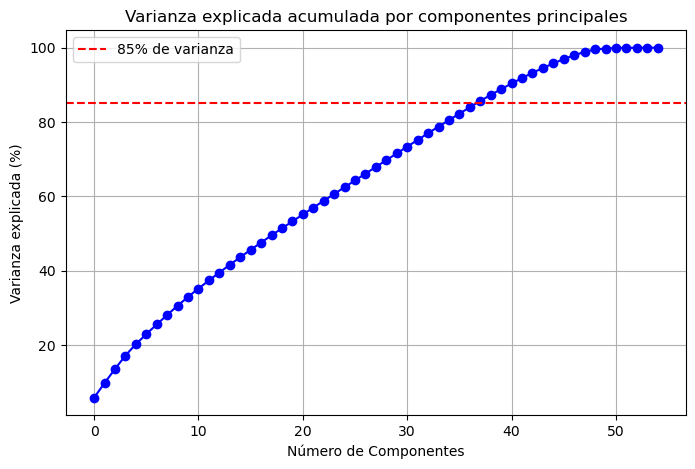


 Interpretación:
- Los primeros 38 componentes explican más del 85% de la varianza total.


In [131]:
# Se crea un gráfico para poder entender mejor la varianza explicada
plt.figure(figsize=(8,5))
plt.plot(varianza, marker='o', color='b')
plt.title("Varianza explicada acumulada por componentes principales")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza explicada (%)")
plt.grid(True)
plt.axhline(y=85, color='r', linestyle='--', label='85% de varianza')
plt.legend()
plt.show()

#Se intenta generar una explicacion general del gráfico y de la varianza.
print("\n Interpretación:")
print(f"- Los primeros {n_componentes} componentes explican más del 85% de la varianza total.")


In [138]:
#Importamos las librerpias que usaremos para la regreción lineal
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
df_secop.columns


Index(['Nombre Entidad', 'Nit Entidad', 'Departamento', 'Ciudad', 'Orden',
       'Sector', 'Rama', 'Estado Contrato', 'Descripcion del Proceso',
       'Tipo de Contrato', 'Modalidad de Contratacion', 'Fecha de Firma',
       'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato',
       'Fecha de Inicio de Ejecucion', 'Fecha de Fin de Ejecucion',
       'TipoDocProveedor', 'Documento Proveedor', 'Proveedor Adjudicado',
       'Es Grupo', 'Es Pyme', 'Habilita Pago Adelantado',
       'Origen de los Recursos', 'Valor del Contrato',
       'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Dias adicionados',
       'Presupuesto General de la Nacion – PGN',
       'Sistema General de Participaciones', 'Sistema General de Regalías',
       'Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas)',
       'Recursos de Credito', 'Recursos Propios', 'Objeto del Contrato',
       'Duración del contrato', 'Año', 'Duración del contrato_dias'],
    

In [161]:
#Seleccionamos 5 variables predictoras
variables_predictoras = [
    'Duración del contrato_dias',
    'Tipo de Contrato',
    'Sector',
    'Es grupo',
    'Modalidad de Contratacion',
    'Es Pyme',
    'Nombre Entidad'
]
#Validamos que existan en el df
variables_existentes = [v for v in variables_predictoras if v in df_secop.columns]
print("✅ Variables incluidas en el modelo:", variables_existentes)

✅ Variables incluidas en el modelo: ['Duración del contrato_dias', 'Tipo de Contrato', 'Sector', 'Modalidad de Contratacion', 'Es Pyme', 'Nombre Entidad']


In [162]:
#Escogimos que la variable dependiente(y) que vamos a predecir será el valor de los contratos
y = df_secop['Valor del Contrato']

# Creamos la matriz de variables independientes
X = df_secop[variables_existentes].copy()

# Convertimos categóricas en dummies (0/1)
X = pd.get_dummies(X, drop_first=True)

# Reemplazamos valos na con 0
X = X.fillna(0)

# Convertimos los valores booleanos a enteros
X = X.astype(int)

# Agregamos la constante (intercepto)
X = sm.add_constant(X)

#Confirmamos que las columnas numéricas tengan el formato requerido
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Creamos el df para el modelo eliminando las filas con valores nulos en y
df_model = pd.concat([y, X], axis=1).dropna()

# Volvemos a separar
y = df_model['Valor del Contrato']
X = df_model.drop(columns=['Valor del Contrato'])

# MODELO OLS
modelo = sm.OLS(y, X).fit()

# Mostramos los resultados
print("\n RESULTADOS DE LA REGRESIÓN LINEAL MÚLTIPLE \n")
print(modelo.summary())


 RESULTADOS DE LA REGRESIÓN LINEAL MÚLTIPLE 

                            OLS Regression Results                            
Dep. Variable:     Valor del Contrato   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     90.94
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:47:45   Log-Likelihood:            -2.0548e+06
No. Observations:               81561   AIC:                         4.110e+06
Df Residuals:                   81515   BIC:                         4.110e+06
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------

Interpretación del modelo:

Métrica	Valor	Interpretación
R²	0.048	indica que el modelo explica el 4.8% de la variación del valor de los contratos, esto es un porcentaje bajo por lo tanto las variable son son muy explicativas.

F-statistic (90.94, p<0.001) Este valor es significativo e indica que el conjunto de variables en su conjunto sí tiene relación con el valor del contrato, aunque el poder explicativo individual sea bajo.

Durbin-Watson ≈ 2.00	No hay autocorrelación entre los residuos (buena señal).	

Cond. No. = 1.19e+16 Este valor es muy alto, indica multicolinealidad severa (algunas variables están fuertemente correlacionadas, posiblemente las dummies de contratos y entidades).	

Variables con efecto significativo (p < 0.05)

Variables cuantitativas:

Duración del contrato (días)
Coeficiente: +5.98e+06
Interpretación: por cada día adicional en la duración del contrato, el valor promedio aumenta en 5.98 millones de pesos, manteniendo las demás variables constantes.

Tipo de contrato:
Todos los tipos de contrato, excepto Concesión, tienen coeficientes negativos muy grandes y altamente significativos, en el orden de –70 a –80 mil millones, mientras que Concesión es positivo.

Tipo de Contrato_Concesión → +6.29e+10
Los contratos de concesión tienden a tener valores mucho más altos que el tipo de referencia (probablemente “Otros” o el omitido en la codificación).

Tipo de Contrato_Prestación de servicios, Consultoría, Suministros, etc. → negativos
Significa que, comparados con el tipo de referencia, suelen tener valores más bajos, lo cual es lógico: los servicios o suministros son de menor monto que obras o concesiones.

Modalidad de contratación:
Licitación pública → +5.22e+09
Licitación pública obra pública → +1.70e+10
Selección Abreviada Menor Cuantía sin manifestación de interés → –1.98e+10
Esto indica que:
Las licitaciones públicas y de obra pública tienden a contratos más altos.
Las contrataciones abreviadas de menor cuantía son de mucho menor valor, como era de esperarse.

Es Pyme_Sí → –2.14e+09 (p<0.001)
Las empresas Pyme tienden a obtener contratos 2.1 mil millones de pesos menores que las grandes empresas, manteniendo todo lo demás constante.

Entidades contratantes (significativas):
Solo dos de las entidades son significativas:
ANSV (Agencia Nacional de Seguridad Vial) → –2.10e+09
ICCU (Instituto de Caminos y Construcciones de Cundinamarca) → –2.28e+09
Sus contratos tienden a ser más bajos que la entidad de referencia (probablemente el Ministerio de Transporte u otra base).

En conclusión:
El modelo es estadísticamente significativo, pero su poder explicativo es bajo (≈5%).
Los contratos de mayor duración, tipo concesión, y licitación pública están asociados con valores más altos.
Las pymes y contrataciones de menor cuantía tienden a tener valores menores.
Algunas entidades específicas muestran diferencias significativas, pero la mayoría no.
Se debe revisar la multicolinealidad y considerar un modelo con menos variables categóricas o con regularización.